# Figure 2: Do LLMs replicate the sparsity effect?

In [1]:
import yaml
import random
import json
import pandas as pd
import seaborn as sns
import numpy as np
import typing
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce

# import kendall_w.kendall_w as kw
import scipy.stats
from tqdm.auto import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import math
import statsmodels.api as sm

# import seaborn_image as isns

sns.set_theme()

In [2]:
def ECDF_transform(arr: np.ndarray):
    return ECDF(arr)(arr)

### Data-loading function

In [3]:
obs = (
    pd.read_pickle("./simulate-comb-A-N/matrix.pkl")[:1_000, :1_000]
    .todense()
    .reshape(-1)
)

In [35]:
adj_freq = pd.read_pickle("./simulate-comb-A-N/adj_freqs.pkl")
noun_freq = pd.read_pickle("./simulate-comb-A-N/noun_freqs.pkl")

In [40]:
def get_results(
    model="gpt2_xl",
    study="composlang",
    paradigm="logprobs",
    basedir=Path("./llm-results/"),
):
    [resultsdir] = (basedir / study).glob("benchmark-cfg=*")
    results = list(resultsdir.glob(f"eval={paradigm}*/model={model}/results.csv"))
    results = [pd.read_csv(r, index_col=0) for r in results]
    if len(results) == 2:
        results = pd.merge(*results)
    elif len(results) == 1:
        results = results[0]
    else:
        raise ValueError(f"Found {len(results)} results")

    results = results[(results.arank >= 0) & (results.nrank >= 0)]

    if paradigm == "logprobs":
        levels = ("metadata", "model")
        model_columns = ["logp_A", "logp_N", "logp_N_A"]
        metadata_columns = results.columns.difference(model_columns)

        mii = pd.MultiIndex.from_tuples(
            tuples=[("metadata", c) for c in results.columns if c in metadata_columns]
            + [("model", c) for c in results.columns if c in model_columns],
            # names=levels,
        )
        results.columns = mii
        results["metadata", "model"] = model

        col = "logp_N_A"
        ecdf = ECDF_transform(results["model", col])
        results["model", f"ecdf_{col}"] = ecdf

        results["model", "pmi"] = (
            results["model", "logp_N_A"] - results["model", "logp_N"]
        ) / math.log(2)

        results["metadata", "observed"] = obs
        results["metadata", "adj_freq"] = results["metadata", "adjective"].map(adj_freq)
        results["metadata", "noun_freq"] = results["metadata", "noun"].map(noun_freq)

    else:
        raise NotImplementedError(f"paradigm={paradigm}!=logprobs")

    return results.sort_index(axis=1)

In [76]:
models = ["gpt2_xl", "phi_2", "mpt_7b", "mpt_7b_chat", "mistral7b"]

In [41]:
gpt2xl = get_results(model="gpt2_xl")
phi2 = get_results(model="phi_2")
mpt7b = get_results(model="mpt_7b")
mpt7bchat = get_results(model="mpt_7b_chat")
# mpt30b = get_results(model="mpt_30b")
# mpt30bchat = get_results(model="mpt_30b_chat")
mistral7b = get_results(model="Mistral_7B_v0.1")

In [42]:
mpt7bchat

metadata                                                           \
        adj_freq   adjective arank        model      noun noun_freq nrank   
20027     738678       other     0  mpt_7b_chat    people    822767     0   
20028     738678       other     0  mpt_7b_chat      time    812441     1   
20029     738678       other     0  mpt_7b_chat     years    559033     2   
20030     738678       other     0  mpt_7b_chat      year    499579     3   
20031     738678       other     0  mpt_7b_chat       way    491262     4   
...          ...         ...   ...          ...       ...       ...   ...   
1020022     4504  unfamiliar   999  mpt_7b_chat      beer     21109   995   
1020023     4504  unfamiliar   999  mpt_7b_chat    option     21087   996   
1020024     4504  unfamiliar   999  mpt_7b_chat       key     21080   997   
1020025     4504  unfamiliar   999  mpt_7b_chat  exchange     21043   998   
1020026     4504  unfamiliar   999  mpt_7b_chat     facts     21041   999   

                         model                                           
        observed ecdf_logp_N_A     logp_A    logp_N  logp_N_A       pmi  
20027      20619      0.999653 -11.875000  -7.40625  -2.03125  7.754486  
20028       1301      0.958600 -11.875000 -11.37500  -7.28125  5.906033  
20029        291      0.550016 -11.875000 -11.37500 -11.56250 -0.270505  
20030        343      0.470481 -11.875000 -12.62500 -12.06250  0.811516  
20031       7711      0.626445 -11.875000 -12.62500 -11.06250  2.254211  
...          ...           ...        ...       ...       ...       ...  
1020022        0      0.663396 -16.835938 -14.09375 -10.81250  4.733843  
1020023        0      0.761914 -16.835938 -12.62500 -10.06250  3.696906  
1020024        0      0.881969 -16.835938 -12.37500  -8.81250  5.139601  
1020025        0      0.816887 -16.835938 -13.12500  -9.56250  5.139601  
1020026        0      0.881969 -16.835938 -14.62500  -8.81250  8.385665  

[1000000 rows x 13 columns]

In [98]:
# set lower and upper bounds using 5% and 95% quantiles
lower_bound = mpt7bchat["metadata", "observed"].quantile(0.01)
upper_bound = mpt7bchat["metadata", "observed"].quantile(0.99)

view = mpt7bchat[
    (mpt7bchat["metadata", "observed"] < upper_bound)
    & (mpt7bchat["metadata", "observed"] > lower_bound)
]


def compute_fit(df, model="model", metric="logp_N_A", lower_pct=0.01, upper_pct=0.99):
    lower_bound = df["metadata", "observed"].quantile(lower_pct)
    upper_bound = df["metadata", "observed"].quantile(upper_pct)

    df = df[
        (df["metadata", "observed"] < upper_bound)
        & (df["metadata", "observed"] > lower_bound)
    ]

    y = df["metadata", "observed"]
    if isinstance(metric, str):
        x = df[model, metric]
    else:
        x = df[model, metric[0]] * df[model, metric[1]]
    model = sm.OLS(y, sm.add_constant(x))
    fit = model.fit()
    return x, y, fit


x, y, fit = compute_fit(view)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     ('metadata', 'observed')   R-squared:                       0.066
Model:                                  OLS   Adj. R-squared:                  0.066
Method:                       Least Squares   F-statistic:                 1.758e+04
Date:                      Fri, 19 Jan 2024   Prob (F-statistic):               0.00
Time:                              12:55:47   Log-Likelihood:            -1.1263e+06
No. Observations:                    249811   AIC:                         2.253e+06
Df Residuals:                        249809   BIC:                         2.253e+06
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    41.6485      0.193    216.075      0.000      41.271      42.026
('model', 'logp_N_A')     2.3693      0.018    132.586      0.000       2.334       2.404
==============================================================================
Omnibus:                   133060.619   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           861523.745
Skew:                           2.575   Prob(JB):                         0.00
Kurtosis:                      10.500   Cond. No.                         47.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

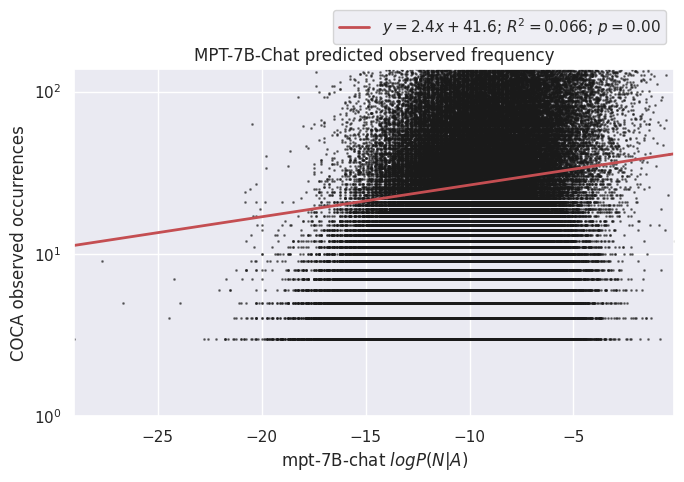

In [91]:
f, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x, y, alpha=0.5, s=1, c="k")
ax.set_yscale("log")
# ax.set_yscale("log")
# extract intercept b and slope m
b, m = fit.params
# plot y = m*x + b
ax.axline(
    xy1=(0, b),
    xy2=(10, 10 * m + b),
    color="r",
    linewidth=2,
    linestyle="-",
    # slope=m,
    label=f"$y = {m:.1f}x {b:+.1f}$; $R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
)
ax.set_xlim(min(x), max(x))
ax.set_ylim(1e-0, max(y) + 1)
ax.legend(loc="lower right", bbox_to_anchor=(1, 1.05))
ax.set_title("MPT-7B-Chat predicted observed frequency")
ax.set_xlabel("mpt-7B-chat $log P(N|A)$")
ax.set_ylabel("COCA observed occurrences")

plt.tight_layout()
plt.show()

In [77]:
models
df = {
    "gpt2xl": gpt2xl,
    "phi2": phi2,
    "mpt7b": mpt7b,
    "mpt7bchat": mpt7bchat,
    "Mistral-7B-v0.1": mistral7b,
}

In [127]:
results = []
for model in df:
    x, y, fit = compute_fit(df[model])
    r2 = fit.rsquared
    p = fit.pvalues[1]
    results.append({"model": model, "r2": r2, "p": p})
    print(
        model,
        f"{fit.rsquared=:.4f}, {fit.pvalues[1]=:.3f}; eqn: y = {fit.params[1]:.3f}x + {fit.params[0]:.3f}",
    )

gpt2xl fit.rsquared=0.0840, fit.pvalues[1]=0.000; eqn: y = 4.163x + 54.250
phi2 fit.rsquared=0.0914, fit.pvalues[1]=0.000; eqn: y = 3.836x + 52.487
mpt7b fit.rsquared=0.0938, fit.pvalues[1]=0.000; eqn: y = 4.327x + 55.110
mpt7bchat fit.rsquared=0.0743, fit.pvalues[1]=0.000; eqn: y = 2.786x + 44.676
Mistral-7B-v0.1 fit.rsquared=0.0729, fit.pvalues[1]=0.000; eqn: y = 3.383x + 47.680


In [128]:
*_, fit = compute_fit(mpt7bchat, model="metadata", metric=["adj_freq", "noun_freq"])
print(
    f"{fit.rsquared=:.4f}, {fit.pvalues.to_list()[1]=:.3f}; eqn: y = {fit.params.to_list()[1]:.3f}x + {fit.params.to_list()[0]:.3f}"
)
results.append(
    {"model": "adj_freq * noun_freq", "r2": fit.rsquared, "p": fit.pvalues.to_list()[1]}
)

fit.rsquared=0.0632, fit.pvalues.to_list()[1]=0.000; eqn: y = 0.000x + 11.820


In [129]:
results = pd.DataFrame(results)
results["model"] += results["p"].apply(lambda val: " (*)" if val < 0.05 else "")
results

,model,r2,p
0,gpt2xl (*),0.084016,0.0
1,phi2 (*),0.091435,0.0
2,mpt7b (*),0.093769,0.0
3,mpt7bchat (*),0.074303,0.0
4,Mistral-7B-v0.1 (*),0.072868,0.0
5,adj_freq * noun_freq (*),0.063154,0.0


Text(0.5, 1.0, 'R-squared of observed frequency in COCA (99%ile outliers removed) vs. model predictions')

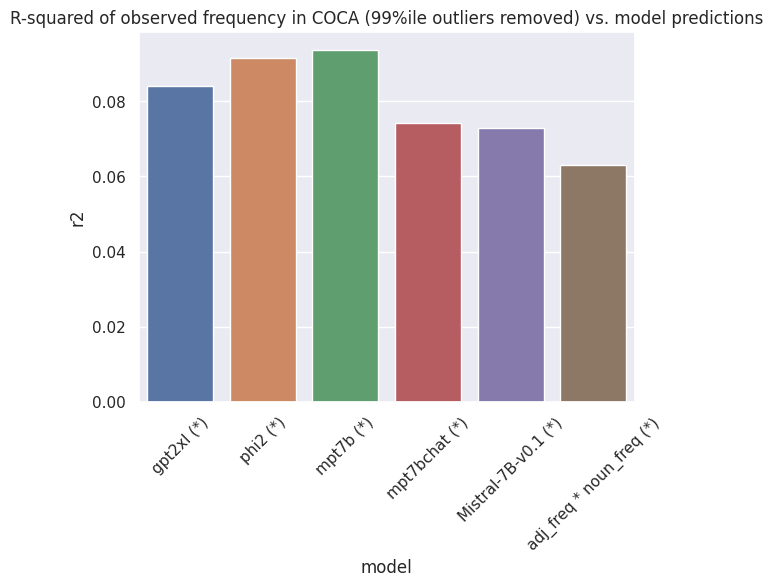

In [132]:
sns.barplot(
    x=results["model"],
    y=results["r2"],
)
# rotate xaxis labels
plt.xticks(rotation=45)
plt.title(
    "R-squared of observed frequency in COCA (99%ile outliers removed) vs. model predictions"
)

In [14]:
def construct_mat(df, col="pmi"):
    model = df.columns[-1][0]
    mat = np.zeros((1000, 1000))
    for i, row in tqdm(df.iterrows(), total=len(df)):
        mat[row.loc[("metadata", "arank")], row.loc[("metadata", "nrank")]] = row.loc[
            (model, "pmi")
        ]
    return mat

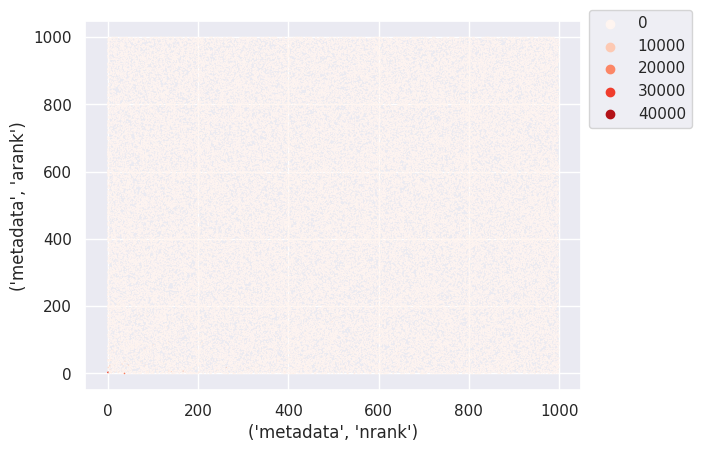

In [74]:
sns.scatterplot(
    data=mpt7bchat.sample(100_000),
    x=("metadata", "nrank"),
    y=("metadata", "arank"),
    hue=("metadata", "observed"),
    edgecolor=None,
    s=1,
    # alpha=0.1,
    palette="Reds",
)
plt.legend(bbox_to_anchor=(1, 1.05))

<AxesSubplot:xlabel='logp_N_A_x', ylabel='logp_N_A_y'>

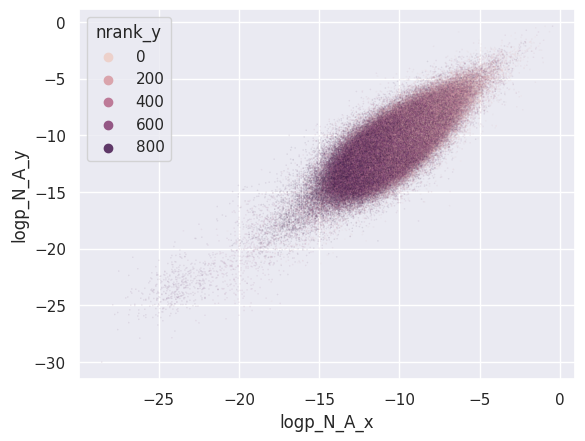

In [106]:
sns.scatterplot(
    data=view.sample(500_000),
    x="logp_N_A_x",
    y="logp_N_A_y",
    hue="nrank_y",
    edgecolor=None,
    s=1,
    alpha=0.1,
    # palette="Reds",
)

<AxesSubplot:xlabel='logp_N_A', ylabel='logp_N'>

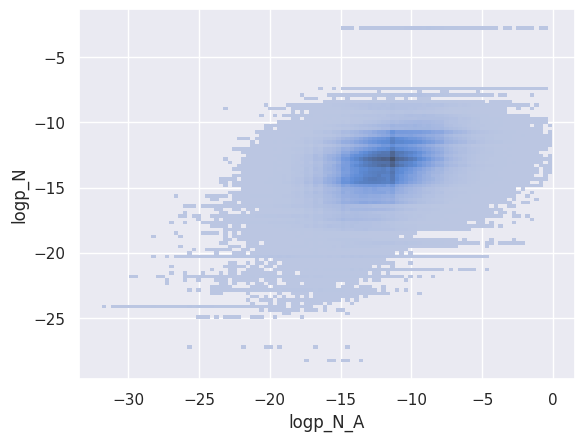

In [19]:
sns.histplot(
    data=mpt7bchat,
    x="logp_N_A",
    y="logp_N",
    # hue="trial_type",
    # edgecolor=None,
    # s=1,
    # alpha=0.1,
    bins=100,
)

In [134]:
gptlogp.apply(lambda x: x["logp_N_A"] - x["logp_N"], axis=1)

0       2.5625
1       5.6875
2       3.1250
3       2.5000
4       3.3750
         ...  
9902    2.5625
9903    4.5000
9904    4.0625
9905    4.8125
9906    6.4375
Length: 9907, dtype: float64